### Importing libraries and data

NEW LINE

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
test_data = pd.read_csv("Data/test.csv")
train_data = pd.read_csv("Data/train.csv")

### Visualizing data and basic statics

In [ ]:
train_data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_data['Product ID'].value_counts()

Product ID
L53257    139
L49056    131
L53271    131
L54275    120
L48892    120
         ... 
M24614      1
H39399      1
M15853      1
H32637      1
L48036      1
Name: count, Length: 9976, dtype: int64

Text(0, 0.5, 'Count')

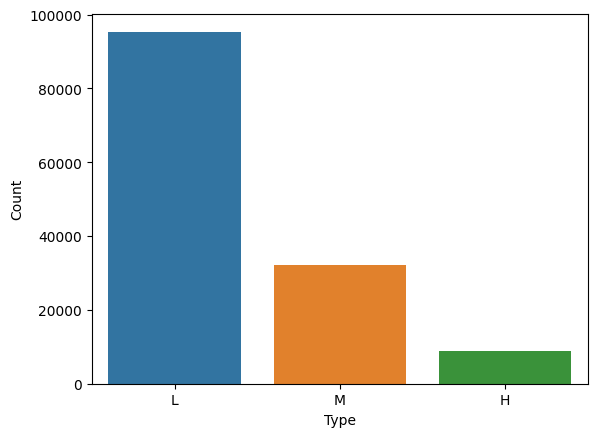

In [ ]:
class_counts = train_data['Type'].value_counts()
sns.barplot(x= class_counts.index, y= class_counts.values)
plt.ylabel('Count')

Text(0, 0.5, 'Count')

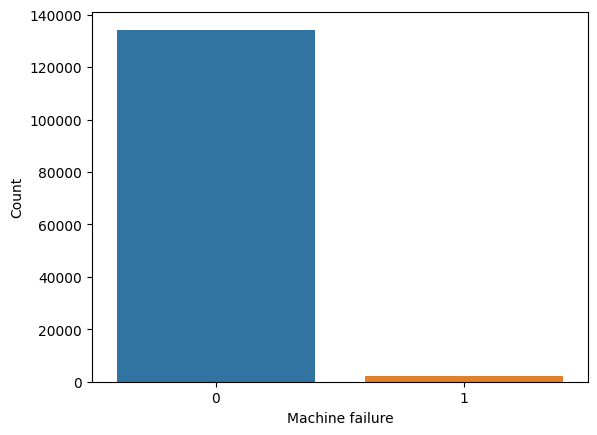

In [ ]:
class_counts = train_data['Machine failure'].value_counts()
sns.barplot(x= class_counts.index, y= class_counts.values)
plt.ylabel('Count')

Very imbalanced data!!

In [ ]:
train_data.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Cleaning data and applying SMOTE to balance data

In [ ]:
train_data.drop(columns=['id', 'Product ID'], axis=1, inplace=True)

In [ ]:
test_data.drop(columns=['id', 'Product ID'], axis=1, inplace=True)

In [ ]:
train_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [ ]:
test_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [ ]:
test_data['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

### One Hot Encoder on feature Type

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(), ['Type'])],
    remainder='passthrough'
)

ctdf = ct.fit_transform(train_data)

train_data = pd.DataFrame(ctdf, columns=ct.get_feature_names_out())
train_data.head()



,one_hot__Type_H,one_hot__Type_L,one_hot__Type_M,remainder__Air temperature [K],remainder__Process temperature [K],remainder__Rotational speed [rpm],remainder__Torque [Nm],remainder__Tool wear [min],remainder__Machine failure,remainder__TWF,remainder__HDF,remainder__PWF,remainder__OSF,remainder__RNF
0,0.0,1.0,0.0,300.6,309.6,1596.0,36.1,140.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,302.6,312.1,1759.0,29.1,200.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,299.3,308.5,1805.0,26.5,25.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,301.0,310.9,1524.0,44.3,197.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,298.0,309.0,1641.0,35.4,34.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for column in train_data.columns:
    train_data.rename(columns={column: column.split('__')[1]}, inplace=True)

train_data.head()

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0.0,1.0,0.0,300.6,309.6,1596.0,36.1,140.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,302.6,312.1,1759.0,29.1,200.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,299.3,308.5,1805.0,26.5,25.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,301.0,310.9,1524.0,44.3,197.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,298.0,309.0,1641.0,35.4,34.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_X = train_data.drop(columns=['Machine failure'], axis=1)
train_y = train_data['Machine failure']

from imblearn.over_sampling import SMOTENC
sm = SMOTENC(random_state= 1, k_neighbors=5, categorical_features=[0])
res_X, res_y = sm.fit_resample(train_X, train_y)

Text(0, 0.5, 'Count')

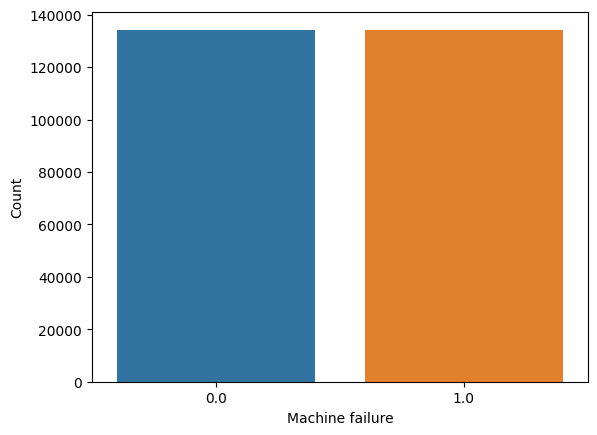

In [ ]:
class_counts = res_y.value_counts()
sns.barplot(x= class_counts.index, y= class_counts.values)
plt.ylabel('Count')

## Classification

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=1)

model.fit(res_X, res_y)
pred = model.predict(test_data)

pred

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Type
Feature names seen at fit time, yet now missing:
- Type_H
- Type_L
- Type_M
